In [38]:
import json
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [9]:
# Declare constants
URL              = 'https://opendata-ajuntament.barcelona.cat/data/'
RENT_PATH        = 'en/dataset/est-mercat-immobiliari-lloguer-mitja-mensual'
CADASTRAL_PATH   = 'en/dataset/est-cadastre-carrecs-tipus-propietari'
SELECT_DATA_PATH = 'api/action/datastore_search_sql?sql=SELECT * from '

In [10]:
# Declare functions
def get_resource_id(web_path: str) -> str:
    """
    Extract and return the first found data-id, in the resource-item class, from the specified URL 
    """
    # Get a str of the HTML content of the page
    html_web_text     = requests.get(URL + web_path).text
    # Parse the str to search inside
    soup              = BeautifulSoup(html_web_text, 'html.parser')
    # Find the resource id; which matches the last year entry id
    web_resource_item = soup.find("li", {"class":"resource-item", "data-id":True})
    # Prevent returning "None" values
    if web_resource_item != None:
        return  web_resource_item["data-id"]


def search_dataset_by_id(data_id: str) -> dict:
    """
    Query a JSON resource by the specified id from a common URL and return it
    """
    # Query the datasets
    table_res_data = requests.get(URL + SELECT_DATA_PATH + f'"{data_id}"')

    table_json_data = {}
    # If found results, transform them to JSON
    try:
        table_json_data = table_res_data.json()
    # If can't transform to JSON, the page don`t found the resources or is down; 
    # so raise an error with the necessary data for manually verifying
    except ValueError:
        print(f'Error loading JSON data from URL "{URL + SELECT_DATA_PATH}"{data_id}"". Status code: {table_res_data.status_code}')

    data_frame = {}
    if table_json_data != {}:
        # return just the necessary fields
        data_frame = table_json_data["result"]["records"]

    return data_frame


def count_NA_rows(NA_rows: pd.core.frame.DataFrame) -> dict:
    """
    Get the DataFrame rows with N/A values and return a dict with the structure:
        {
            "suburb name": ["number of N/A rows", "district of the suburb"]
        }
    """
    NA_dict = {}
    # Iterate through the rows in the passed DataFrame slice
    for idx_row, NA_row in NA_rows.iterrows():
        # Add the new suburbs in the dict
        if NA_row["Nom_Barri"] not in NA_dict:
            NA_dict[NA_row["Nom_Barri"]] = [1, NA_row["Nom_Districte"]]

        else:
            # If the suburb already exists in the dict, just sum 1 to the number-of-rows-counter
            NA_dict[NA_row["Nom_Barri"]][0] += 1
        
    return NA_dict


def set_NA_corrections(NA_dict: dict, concept: str) -> dict:
    """
    Get a dict with info of the suburbs with N/A price values and search in the rent dataset
    for rows with existing value per suburb, returning its mean price; if not exist any other row,
    return the mean price of the belonging district
    """
    correct_dict = {}
    # iterate through the keys of the passed N/A suburbs dict
    for suburb in NA_dict:
        # If the N/A rows of the suburb is equal 8 (means there is no correct entries in the rent dataset for this suburb)
        if NA_dict[suburb][0] == 8:
            # Set the variables as district name
            price_zone, name_zone = "Nom_Districte", NA_dict[suburb][1]

        else:
            # If there is less than 8 incorrect rows,
            # set the variables as suburb name
            price_zone, name_zone = "Nom_Barri", suburb
        # Search for the correct rows in the rent dataset for suburb or belonging district, as specified above
        suburb_filled_rows = RENT_DATASET[(RENT_DATASET["Lloguer_mitja"] == concept) & (RENT_DATASET[price_zone] == name_zone) & (RENT_DATASET["Preu"] != "N/A")]
        # Calculate the mean of the price per row found
        price_mean         = round(suburb_filled_rows["Preu"].astype("float").mean(), 1)
        # Add that prices in the "correct dict"
        correct_dict[suburb] = price_mean

    return correct_dict


def get_suburbs_list() -> list:
    """
    Return a list with all the suburbs name without duplicates
    """
    sub_list= []
    # Iterate through the suburb names in the rent dataset
    for suburb in RENT_DATASET["Nom_Barri"]:
        # Add the names with no duplicates to the final list
        if suburb not in sub_list:
            sub_list.append(suburb)
    
    return sub_list


def get_dataset_cols(dataset: pd.core.frame.DataFrame, sub_list: list, correct_prices: dict, price_col: str, sub_col: str, concept_col: str, concept_value: str) -> list:
    """
    Return a list with the values of the specified fields from the passed datasets, ordered by a list of suburbs name
    """
    col_list = []
    # Iterate through the list of suburb names
    for sub in sub_list:
        # Search in the passed dataset the values of the passed columns (cadastral or rent values)
        monthly_price = dataset[(dataset[concept_col] == concept_value) & (dataset[sub_col] == sub)][price_col]
        
        try:
            col_list.append(round(monthly_price.astype("float").mean(), 1))
        # If there is a N/A values will raise a Value Error,
        # so access the passed correct-N/A-prices-dict for the correct values to add to the final list
        except ValueError:
            col_list.append(correct_prices[concept_value][sub])
    
    return col_list

<h3>First Step: Web Scraping</h3>

The Barcelona council website has an API for query their resources (datasets);<br>
so first we get the resource id, according with the last year entry, from the URLs on the top of the page code

In [11]:
data_ids_dict = {}
# construct a dict with the dataset name (rent or cadastral) and his id
for web_path, dataset_name in ((RENT_PATH, "rent"), (CADASTRAL_PATH, "cadastral")):
    data_ids_dict[dataset_name] = get_resource_id(web_path)

Query the ids to get the datasets

In [12]:
data_frames_dict = {}

for data_id_key in data_ids_dict:
    # Query the datasets
    search_result = search_dataset_by_id(data_ids_dict[data_id_key])
    # If found the data, turn it into a Pandas DataFrame
    if search_result != {}:
        data_frames_dict[data_id_key] = pd.DataFrame(search_result)
    

In [13]:
# Declare the datasets constants
RENT_DATASET      = data_frames_dict["rent"]
CADASTRAL_DATASET = data_frames_dict["cadastral"]

<h3>Second Step: Data Analysing and Preprocessing</h3>

Let's take a quick look at the data.

The rent dataset in his first half has the average rent prices (according to the "Lloguer_mitja" column), and other values,<br>
per suburb per each quarter. On the other half, the same but prices per square meter.

In [14]:
# First half sample values
# (there are one row per suburb (ordered by quarter), so checking the head and tail we get different samples)
RENT_DATASET.head(3)

,Codi_Districte,Lloguer_mitja,Nom_Districte,_full_text,Trimestre,Preu,Nom_Barri,Codi_Barri,_id,Any
0,1,Lloguer mitjà mensual (Euros/mes),Ciutat Vella,'1':3 '2020':4 '864.5':9 'ciutat':1 'el':10 'e...,1,864.5,el Raval,1,1,2020
1,1,Lloguer mitjà mensual (Euros/mes),Ciutat Vella,'1':4 '1110.2':3 '2':5 '2020':6 'barri':8 'ciu...,1,1110.2,el Barri Gòtic,2,2,2020
2,1,Lloguer mitjà mensual (Euros/mes),Ciutat Vella,'1':6 '2020':8 '3':7 '899.5':1 'barceloneta':5...,1,899.5,la Barceloneta,3,3,2020


In [15]:
# Second half sample values
RENT_DATASET.tail(3)

,Codi_Districte,Lloguer_mitja,Nom_Districte,_full_text,Trimestre,Preu,Nom_Barri,Codi_Barri,_id,Any
581,10,Lloguer mitjà per superfície (Euros/m2 mes),Sant Martí,'10':1 '12.6':16 '2020':7 '4':8 '71':9 'del':3...,4,12.6,Provençals del Poblenou,71,582,2020
582,10,Lloguer mitjà per superfície (Euros/m2 mes),Sant Martí,'10':1 '11.8':6 '2020':9 '4':17 '72':10 'de':4...,4,11.8,Sant Martí de Provençals,72,583,2020
583,10,Lloguer mitjà per superfície (Euros/m2 mes),Sant Martí,'10':1 '11.6':7 '2020':18 '4':11 '73':10 'euro...,4,11.6,la Verneda i la Pau,73,584,2020


The cadastral dataset in his first half has the cadastral prices (according to the "Concepte" column), and other values,<br>
per registered person; one suburb has multiple entries. On the other half the same but, instead of prices, the number of<br>
properties per person.

In [43]:
# First half sample values
# (the entries are ordered per suburbs names, so for get a different samples we need to extract it randomly)
CADASTRAL_DATASET[CADASTRAL_DATASET["Concepte"] == "Valor_cadastral"].sample(3)

,Concepte,Codi_districte,Desc_tipus_propietari,Nom_districte,_full_text,Nom_barri,Seccio_censal,Valor,Codi_barri,_id,Any
7195,Valor_cadastral,2,Subjecte físic,Eixample,'2':6 '2020':7 '40':5 '6':13 '62655011.50':4 '...,la Sagrada Família,40,62655011.50,6,7193,2020
1198,Valor_cadastral,2,Altres,Eixample,'180919.87':5 '2':2 '2020':3 '4':4 '5':9 'altr...,el Fort Pienc,4,180919.87,5,1194,2020
2547,Valor_cadastral,7,Altres,Horta-Guinardó,'2020':7 '41':5 '4185.78':1 '7':12 '98':6 'alt...,la Vall d'Hebron,98,4185.78,41,2534,2020


In [44]:
# Second half sample values
CADASTRAL_DATASET[CADASTRAL_DATASET["Concepte"] == "Nombre"].sample(3)

,Concepte,Codi_districte,Desc_tipus_propietari,Nom_districte,_full_text,Nom_barri,Seccio_censal,Valor,Codi_barri,_id,Any
11719,Nombre,5,Altres,Sarrià-Sant Gervasi,'17':2 '2020':11 '23':3 '39':1 '5':9 'altr':12...,Sarrià,17,39,23,11718,2020
11574,Nombre,4,Altres,Les Corts,'19':3 '2':5 '2020':6 '32':4 '4':7 'altr':11 '...,les Corts,32,2,19,11573,2020
11079,Nombre,2,Subjecte físic,Eixample,'10':1 '1624':5 '168':7 '2':6 '2020':11 'anton...,Sant Antoni,168,1624,10,11077,2020


There is a little discrepancy on the suburb names between the rent and cadastral datasets; let's solved quickly.

In [18]:
new_name = ["el Barri Gòtic", "el Putxet i el Farró", "la Vila de Gràcia", "el Camp de l'Arpa del Clot"]
old_name = ["el Gòtic", "el Putget i Farró", "Vila de Gràcia", "Camp de l'Arpa del Clot"]
# Replace the DataFrame values which match the first list, with the second list values; ordered
CADASTRAL_DATASET = CADASTRAL_DATASET.replace(old_name, new_name)

There is no N/A values in the only column we are interested for in the cadastral dataset.

In [19]:
CADASTRAL_DATASET[(CADASTRAL_DATASET["Valor"] == "N/A")]

,Concepte,Codi_districte,Desc_tipus_propietari,Nom_districte,_full_text,Nom_barri,Seccio_censal,Valor,Codi_barri,_id,Any


But there are some N/A values in the rent dataset in the column we need.

In [20]:
RENT_DATASET[(RENT_DATASET["Preu"] == "N/A")]

,Codi_Districte,Lloguer_mitja,Nom_Districte,_full_text,Trimestre,Preu,Nom_Barri,Codi_Barri,_id,Any
11,3,Lloguer mitjà mensual (Euros/mes),Sants-Montjuïc,'1':3 '12':1 '2020':8 '3':4 'del':11 'euros/me...,1,N/A,la Marina del Prat Vermell,12,12,2020
42,7,Lloguer mitjà mensual (Euros/mes),Horta-Guinardó,'1':8 '2020':9 '42':6 '7':10 'clota':2 'euros/...,1,N/A,la Clota,42,42,2020
47,8,Lloguer mitjà mensual (Euros/mes),Nou Barris,'1':5 '2020':6 '47':3 '8':7 'barri':13 'euros/...,1,N/A,Can Peguera,47,47,2020
55,8,Lloguer mitjà mensual (Euros/mes),Nou Barris,'1':4 '2020':5 '56':2 '8':6 'barri':12 'euros/...,1,N/A,Vallbona,56,56,2020
84,3,Lloguer mitjà per superfície (Euros/m2 mes),Sants-Montjuïc,'1':3 '12':1 '2020':8 '3':4 'del':17 'euros/m2...,1,N/A,la Marina del Prat Vermell,12,85,2020
114,7,Lloguer mitjà per superfície (Euros/m2 mes),Horta-Guinardó,'1':8 '2020':9 '42':6 '7':10 'clota':2 'euros/...,1,N/A,la Clota,42,115,2020
119,8,Lloguer mitjà per superfície (Euros/m2 mes),Nou Barris,'1':5 '2020':6 '47':3 '8':13 'barri':15 'euros...,1,N/A,Can Peguera,47,120,2020
128,8,Lloguer mitjà per superfície (Euros/m2 mes),Nou Barris,'1':4 '2020':5 '56':2 '8':12 'barri':14 'euros...,1,N/A,Vallbona,56,129,2020
157,3,Lloguer mitjà mensual (Euros/mes),Sants-Montjuïc,'12':1 '2':7 '2020':8 '3':6 'del':11 'euros/me...,2,N/A,la Marina del Prat Vermell,12,158,2020
187,7,Lloguer mitjà mensual (Euros/mes),Horta-Guinardó,'2':8 '2020':9 '42':6 '7':10 'clota':2 'euros/...,2,N/A,la Clota,42,188,2020


The next block counts which suburbs has N/A values, which district it belongs<br>
and if there is any entry with correct values for that suburb.

In [21]:
# Get a slice with the N/A rows
NA_rows               = RENT_DATASET[(RENT_DATASET["Preu"] == "N/A")]
# Count the N/A suburbs
NA_suburbs_price_dict = count_NA_rows(NA_rows)

Suburbs with number "8" has no entries with correct numbers because<br>
there are only 8 entries per suburb in the rent dataset.

In [22]:
NA_suburbs_price_dict

{'la Marina del Prat Vermell': [8, 'Sants-Montjuïc'],
 'la Clota': [8, 'Horta-Guinardó'],
 'Can Peguera': [8, 'Nou Barris'],
 'Vallbona': [8, 'Nou Barris'],
 'Canyelles': [2, 'Nou Barris'],
 'Torre Baró': [6, 'Nou Barris'],
 'Baró de Viver': [6, 'Sant Andreu']}

In other projects we could remove the suburbs without numeric entries in the rent dataset,<br>
because it is our target value for the ML model, but with just 73 example cases I rather to<br>
set the district average price for this suburbs as our target. For the others which has just a few entries (less than 8)<br>
I calculate the mean of the existing rows for his prices.

In [23]:
NA_prices_correction_dict = {}
# The "price_concept" variable safes the parameter for accesing the rent/month or price/square meter values in the rent DataFrame.
# We store the corrected prices per suburb in a dict.
for price_concept in ("Lloguer mitjà mensual (Euros/mes)", "Lloguer mitjà per superfície (Euros/m2 mes)"):
    NA_prices_correction_dict[price_concept] = set_NA_corrections(NA_suburbs_price_dict, price_concept)

In [24]:
NA_prices_correction_dict

{'Lloguer mitjà mensual (Euros/mes)': {'la Marina del Prat Vermell': 843.1,
  'la Clota': 800.3,
  'Can Peguera': 678.5,
  'Vallbona': 678.5,
  'Canyelles': 789.1,
  'Torre Baró': 452.0,
  'Baró de Viver': 584.1},
 'Lloguer mitjà per superfície (Euros/m2 mes)': {'la Marina del Prat Vermell': 13.3,
  'la Clota': 12.4,
  'Can Peguera': 11.3,
  'Vallbona': 11.3,
  'Canyelles': 9.9,
  'Torre Baró': 6.2,
  'Baró de Viver': 7.9}}

In [25]:
# Get a list of suburb names
suburbs_list = get_suburbs_list()

In [26]:
# Extract the average values of the rent price per month, square meter price per month, cadastral price and number of properties; all per suburb;
# from the correct datsets, according to the passed column names.
x1_list     = get_dataset_cols(CADASTRAL_DATASET, suburbs_list, NA_prices_correction_dict, "Valor", "Nom_barri", "Concepte", "Valor_cadastral")
x2_list     = get_dataset_cols(CADASTRAL_DATASET, suburbs_list, NA_prices_correction_dict, "Valor", "Nom_barri", "Concepte", "Nombre")
x3_list     = get_dataset_cols(RENT_DATASET, suburbs_list, NA_prices_correction_dict, "Preu", "Nom_Barri", "Lloguer_mitja", "Lloguer mitjà per superfície (Euros/m2 mes)")
target_list = get_dataset_cols(RENT_DATASET, suburbs_list, NA_prices_correction_dict, "Preu", "Nom_Barri", "Lloguer_mitja", "Lloguer mitjà mensual (Euros/mes)")

<h3>Thrid part: Machine Learning</h3>

Our goal is to find a linear correlation between the cadastral price average<br>
and the rent price per month average.

In [27]:
# Get our X and Y variables as matrix
# X = cadastral prices, number of properties and price per square meter per month
# Y = rent price per month
X = np.array([x1_list, x2_list, x3_list]).T
Y = np.array(target_list)

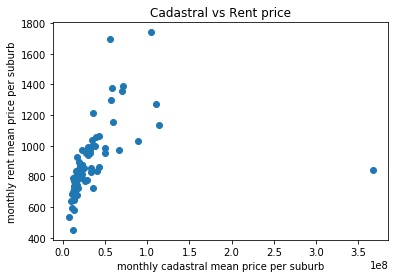

In [28]:
plt.title("Cadastral vs Rent price")
plt.xlabel("monthly cadastral mean price per suburb")
plt.ylabel("monthly rent mean price per suburb")
plt.scatter(X[:,0], Y)
plt.show()

In [29]:
#split in train and test 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.22, random_state=8)

We use a Linear Regression model, as searching for a linear correlation<br>
with more than one feature.

Training an comparing two cases; the "train" and "test" data sets

In [30]:
#training the model with the "train" set
reg_1 = LinearRegression().fit(X_train, Y_train)

Despite the coefficient of determination is reasonably good, the mean squared error<br>
is considerable; that comes from the extremely little number of example cases (just 73)

In [35]:
#evaluting the "train" model
Y_trained_1 = reg_1.predict(X_train)

mse      = np.sqrt(mean_squared_error(Y_train, Y_trained_1))
R2_score = reg_1.score(X_train, Y_train)

print('Mean squared error: ', mse)
print('Coefficient of determination: ', R2_score)

Mean squared error:  157.57422657934782
Coefficient of determination:  0.6174256143964747


In [32]:
#training the model with the "test" set
reg_2 = LinearRegression().fit(X_test, Y_test)

The "test" model metrics are razonably better than the previous model<br>
but it is a not good mesure either because changing the hyperparameters minimaly<br> 
(in this case, test_size and random_state of the split function)<br>
we get a high variation in the results; so it comes from a poor number of examples to evaluate.

In [36]:
#evaluting the "test" model
Y_trained_2 = reg_2.predict(X_test)

mse      = np.sqrt(mean_squared_error(Y_test, Y_trained_2))
R2_score = reg_2.score(X_test, Y_test)

print('Mean squared error: ', mse)
print('Coefficient of determination: ', R2_score)

Mean squared error:  51.070561018298534
Coefficient of determination:  0.8169444493626401


Finally, plotting the original data and the predictions of the "test" and "train" models<br>
to compare the results more visually, we found that despite the poor measures, the results are as accurate as possible.

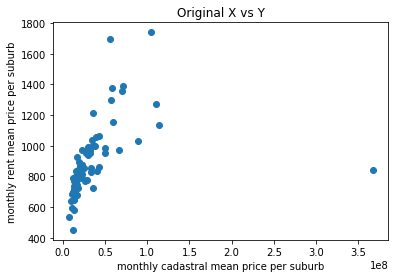

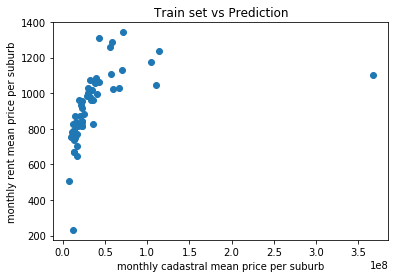

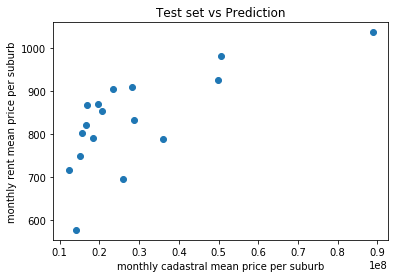

In [34]:
plt.title("Original X vs Y")
plt.xlabel("monthly cadastral mean price per suburb")
plt.ylabel("monthly rent mean price per suburb")
plt.scatter(X[:,0], Y)
plt.show()
plt.title("Train set vs Prediction")
plt.xlabel("monthly cadastral mean price per suburb")
plt.ylabel("monthly rent mean price per suburb")
plt.scatter(X_train[:,0], Y_trained_1)
plt.show()
plt.title("Test set vs Prediction")
plt.xlabel("monthly cadastral mean price per suburb")
plt.ylabel("monthly rent mean price per suburb")
plt.scatter(X_test[:,0], Y_trained_2)
plt.show()

My conclusion is that the linear correlation between the cadastral price of a suburb<br>
and the rental price of that same area, is a fact.
<br><br>
It is, perhaps, an obvious insight but was a great experience and is a good one<br>
practice certifying what we consider obvious.

Thank you so match for arriving here and have a nice day.